# CycleGan
- Need to extract apple2orange

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
from models.CycleGAN import CycleGAN


Using TensorFlow backend.
C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Miniconda3\envs\keras\lib\sit

In [2]:
from glob import glob
import numpy as np
import cv2

import scipy.misc

class DataLoader():
  def __init__(self, dataset_name, img_res=(256, 256)):
    self.dataset_name = dataset_name
    self.img_res = img_res
    
  def load_data(self, domain, batch_size=1, is_testing=False):

      data_type = "train%s" % domain if not is_testing else "test%s" % domain
      path = glob('./data/%s/%s/*' % (self.dataset_name, data_type))
      batch_images = np.random.choice(path, size=batch_size)

      imgs = []
      for img_path in batch_images:
        img = self.imread(img_path)
        if not is_testing:
          img = cv2.resize(img, self.img_res, interpolation=cv2.INTER_CUBIC)
          if np.random.random() > 0.5:
            img = np.fliplr(img)
          else:
            img = cv2.resize(img, self.img_res, interpolation=cv2.INTER_CUBIC)
          imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

  def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = cv2.resize(img_A, self.img_res, interpolation=cv2.INTER_CUBIC)
                img_B = cv2.resize(img_B, self.img_res, interpolation=cv2.INTER_CUBIC)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

  def load_img(self, path):
        img = self.imread(path)
        img = cv2.resize(img, self.img_res, interpolation=cv2.INTER_CUBIC)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

  def imread(self, path):
      return cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float)

In [3]:
# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'apple2orange'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER, exist_ok=True)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' # 

In [4]:
IMAGE_SIZE = 128
data_loader = DataLoader(dataset_name=DATA_NAME, img_res=(IMAGE_SIZE, IMAGE_SIZE))

In [5]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
    ,learning_rate = 0.0002
    , buffer_max_length = 50
    , lambda_validation = 1
    , lambda_reconstr = 10
    , lambda_id = 2
    , generator_type = 'unet'
    , gen_n_filters = 32
    , disc_n_filters = 32
    )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [6]:
BATCH_SIZE = 1
EPOCHS = 10 # 200
PRINT_EVERY_N_BATCHES = 10

TEST_A_FILE = 'n07740461_14740.jpg'
TEST_B_FILE = 'n07749192_4241.jpg'

gan.train(data_loader
        , run_folder = RUN_FOLDER
        , epochs=EPOCHS
        , test_A_file = TEST_A_FILE
        , test_B_file = TEST_B_FILE
        , batch_size=BATCH_SIZE
        , sample_interval=PRINT_EVERY_N_BATCHES)

C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/10] [Batch 0/995] [D loss: 1.409438, acc:  32%] [G loss: 21.529219, adv: 1.486391, recon: 1.670984, id: 1.666495] time: 0:00:22.530320 


C:\ProgramData\Miniconda3\envs\keras\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/10] [Batch 100/995] [D loss: 0.301648, acc:  61%] [G loss: 13.291384, adv: 0.859460, recon: 1.041310, id: 1.009414] time: 0:00:37.104112 
[Epoch 0/10] [Batch 200/995] [D loss: 0.234121, acc:  62%] [G loss: 7.710287, adv: 0.609000, recon: 0.590803, id: 0.596628] time: 0:00:51.610702 
[Epoch 0/10] [Batch 300/995] [D loss: 0.209865, acc:  64%] [G loss: 8.846753, adv: 0.873102, recon: 0.664422, id: 0.664715] time: 0:01:06.133650 
[Epoch 0/10] [Batch 400/995] [D loss: 0.377094, acc:  46%] [G loss: 7.237069, adv: 0.946684, recon: 0.522360, id: 0.533392] time: 0:01:20.615410 
[Epoch 0/10] [Batch 500/995] [D loss: 0.149596, acc:  75%] [G loss: 8.397715, adv: 0.811809, recon: 0.632955, id: 0.628179] time: 0:01:35.385216 
[Epoch 0/10] [Batch 600/995] [D loss: 0.276979, acc:  54%] [G loss: 8.856502, adv: 0.939866, recon: 0.660441, id: 0.656114] time: 0:01:49.983063 
[Epoch 0/10] [Batch 700/995] [D loss: 0.111340, acc:  90%] [G loss: 6.772489, adv: 0.818340, recon: 0.499619, id: 0.478982]

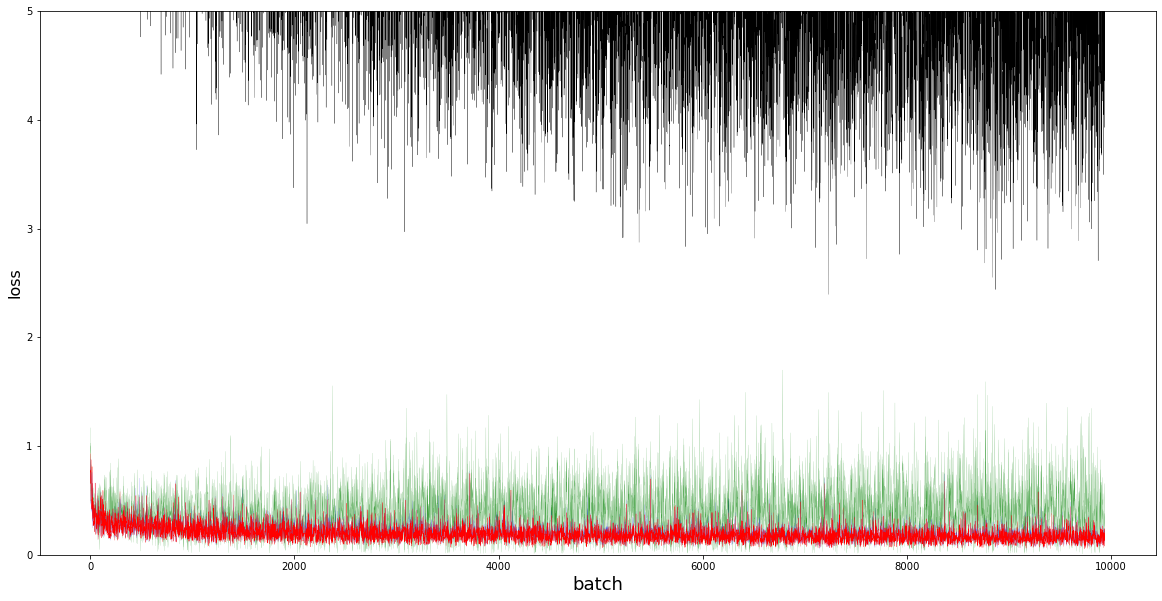

In [7]:
fig = plt.figure(figsize=(20,10))

plt.plot([x[1] for x in gan.g_losses], color='green', linewidth=0.1) #DISCRIM LOSS
# plt.plot([x[2] for x in gan.g_losses], color='orange', linewidth=0.1)
plt.plot([x[3] for x in gan.g_losses], color='blue', linewidth=0.1) #CYCLE LOSS
# plt.plot([x[4] for x in gan.g_losses], color='orange', linewidth=0.25)
plt.plot([x[5] for x in gan.g_losses], color='red', linewidth=0.25) #ID LOSS
# plt.plot([x[6] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.plot([x[0] for x in gan.g_losses], color='black', linewidth=0.25)

# plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.show()